FIJATE SI VARIANDO LOS THRESHOLDS DEL LDA MEJORA EL CLASSIFIER.
Hace train test split para sacar un f1 score mas cierto y evitar el overfitting
undersampling mejora el overfitting..todo eso puede llegar a sumar!

In [1]:
#librerias necesarias

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import datetime

sns.set(style='dark', context='notebook', palette='plasma')

In [2]:
#get datos
train_path = 'C:\\Users\\desar\\OneDrive\\Escritorio\\data_science\\Competencia apps google store\\train.csv'
test_path = 'C:\\Users\\desar\\OneDrive\\Escritorio\\data_science\\Competencia apps google store\\test.csv'
train_set = pd.read_csv(train_path, parse_dates = ['Last Updated'], index_col = 'ID')
test_set = pd.read_csv(test_path, index_col = 'ID', parse_dates = ['Last Updated'])

# Exploro y limpio datos

In [3]:
train_set.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
ID,,,,,,,,,,,,,
0,GPS Status & Toolbox,TRAVEL_AND_LOCAL,1.0,149723,4.1M,"10,000,000+",Free,0,Everyone,Travel & Local,2018-06-13,8.1.171,4.0 and up
1,Fish|Hunt FL,LIFESTYLE,0.0,853,34M,"100,000+",Free,0,Everyone,Lifestyle,2018-03-22,3.2.0,4.1 and up
2,Allrecipes Dinner Spinner,FOOD_AND_DRINK,1.0,61881,Varies with device,"5,000,000+",Free,0,Everyone,Food & Drink,2018-04-10,Varies with device,Varies with device
3,Don't touch my phone,TOOLS,0.0,21943,2.3M,"5,000,000+",Free,0,Everyone,Tools,2016-10-19,30,2.3 and up
4,BM SPM Practice,FAMILY,1.0,6,9.2M,"1,000+",Free,0,Everyone,Education,2018-01-24,1.0,4.1 and up


In [4]:
train_set.describe()

,Rating,Reviews
count,5788.000000,5.788000e+03
mean,0.745853,2.341452e+05
std,0.435418,2.174469e+06
min,0.000000,0.000000e+00
25%,0.000000,2.300000e+01
50%,1.000000,8.890000e+02
75%,1.000000,2.643250e+04
max,1.000000,7.815831e+07


In [5]:
train_set.info()     

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5788 entries, 0 to 5787
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   App             5788 non-null   object        
 1   Category        5788 non-null   object        
 2   Rating          5788 non-null   float64       
 3   Reviews         5788 non-null   int64         
 4   Size            5788 non-null   object        
 5   Installs        5788 non-null   object        
 6   Type            5788 non-null   object        
 7   Price           5788 non-null   object        
 8   Content Rating  5788 non-null   object        
 9   Genres          5788 non-null   object        
 10  Last Updated    5788 non-null   datetime64[ns]
 11  Current Ver     5788 non-null   object        
 12  Android Ver     5788 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(10)
memory usage: 633.1+ KB


Hay 5788 datos
No hay NaNs
Solo dos cols de numero, aunque precio installs y size son numericas pero un poco sucias las var..
La unica datetime ya esta bien parsed
desp las versiones hay que ver como se manejan

In [6]:
test_set.head(3)

,App,Category,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
ID,,,,,,,,,,,,
5788,Bk Usha behn,LIFESTYLE,10,3.0M,"1,000+",Free,0,Everyone,Lifestyle,2018-01-14,1.0,4.1 and up
5789,Funny Ringtones,PERSONALIZATION,7146,14M,"1,000,000+",Free,0,Everyone 10+,Personalization,2018-02-02,1.1,4.0 and up
5790,Strava.cz,SHOPPING,2221,Varies with device,"100,000+",Free,0,Everyone,Shopping,2018-07-10,Varies with device,Varies with device


In [7]:
#genres y category parecen ser similares
print(len(train_set['Category'].unique().tolist()), len(train_set['Genres'].unique().tolist()))
#mmm nop, hay que seguir viendo. Genres parece ser mas detallado

33 107


In [8]:
distintos = []
for i in train_set['Genres'].unique().tolist():
    if i in train_set['Category'].unique().tolist():
        distintos.append(i)

len(distintos)

#esto pasa porque nada que ver el formato de las dos! gil

0

In [9]:
#formateo datos en category como estan mas limpitos en genres
for df in [train_set, test_set]:
    df['Category'] = df['Category'].str.replace('_',' ')
    df['Category'] = df['Category'].str.title()
    df['Category'] = df['Category'].str.replace('And','&', regex = True) #el and con mayuscula por el title()

In [10]:
train_set['Category'].unique() #ahora vemos que quedo lindo

array(['Travel & Local', 'Lifestyle', 'Food & Drink', 'Tools', 'Family',
       'Art & Design', 'Medical', 'News & Magazines', 'Finance', 'Game',
       'Productivity', 'House & Home', 'Sports', 'Video Players',
       'Education', 'Entertainment', 'Health & Fitness', 'Business',
       'Communication', 'Dating', 'Books & Reference', 'Personalization',
       'Social', 'Photography', 'Libraries & Demo', 'Weather',
       'Maps & Navigation', 'Shopping', 'Parenting', 'Events', 'Comics',
       'Auto & Vehicles', 'Beauty'], dtype=object)

In [11]:
#probamos ahora
distintos = []
for i in train_set['Genres'].unique().tolist():
    if i not in train_set['Category'].unique().tolist():
        distintos.append(i)
len(distintos)
#vemos que 77 valores de Genres no estan en category, 30 si
#solo 3 datos de category no se repiten en genre
#cada dato de category tiene como subcategoria aprox 3 a 4 datos de genre

77

In [12]:
#el titulo aparentemente no suma en nada asi que lo rajo
#la version de la app tampoco..
for df in [train_set, test_set]:
    df.drop(['App', 'Current Ver'], inplace = True, axis = 1)

In [13]:
#el precio tiene el signo pesos que tamb lo podemos rajar
#el install tiene el + que tamb chau
for df in [train_set, test_set]:
    df['Price'] = df['Price'].str.replace('$', '')
    df['Price'].astype(float)
    
train_set['Rating'] = train_set['Rating'].astype(int) #y a rating lo cambiamos tamb

In [14]:
#con el installs parecen numeros a full
#vemos si son var categoricas o numeros continuos, el + ese hace sospechar
train_set['Installs'].unique()
#sip, es categorica, con un simple imputer la manejamos ok

array(['10,000,000+', '100,000+', '5,000,000+', '1,000+', '5,000+',
       '10,000+', '100+', '100,000,000+', '500,000+', '50,000+', '10+',
       '50,000,000+', '1,000,000+', '50+', '1,000,000,000+', '500+', '1+',
       '5+', '500,000,000+', '0+'], dtype=object)

In [15]:
#hay que ver cuantos datos son varies with device que lo tengo que considerar como NaN aca!

In [16]:
def limpiarSizes(x): #Funcion de Franco.. el apply es posta
    if str(x)[-1] == 'k':
        return float(str(x)[:-1])/1024
    elif str(x)[-1] == 'M':
        return float(str(x)[:-1])
    else:
        return None
    
for df in [train_set, test_set]:
    df['Size_ok'] = df['Size'].apply(limpiarSizes)
    df.drop('Size', axis = 1, inplace = True)
    df.rename(columns = {'Size_ok':'Size'}, inplace = True)

In [17]:
train_set.Size.isnull().value_counts()
#tengo 728 NaNs en Size..

False    5060
True      728
Name: Size, dtype: int64

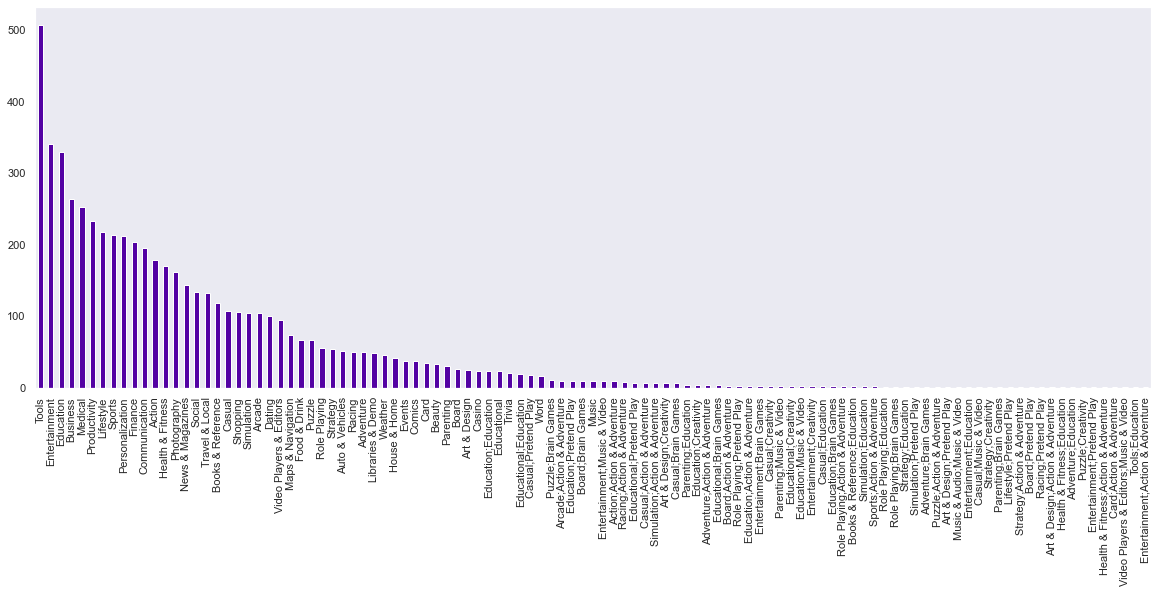

In [18]:
# a genres podes hacerle un count y a los que sean poquitos los agrupas en categoria otros para no overfittear!

#val_genero = pd.Series(train_set.Genres.value_counts())
#sns.barplot(x = val_genero.index, y = val_genero.values, ci = None);

train_set.Genres.value_counts().plot(kind = 'bar', figsize = (20,7));

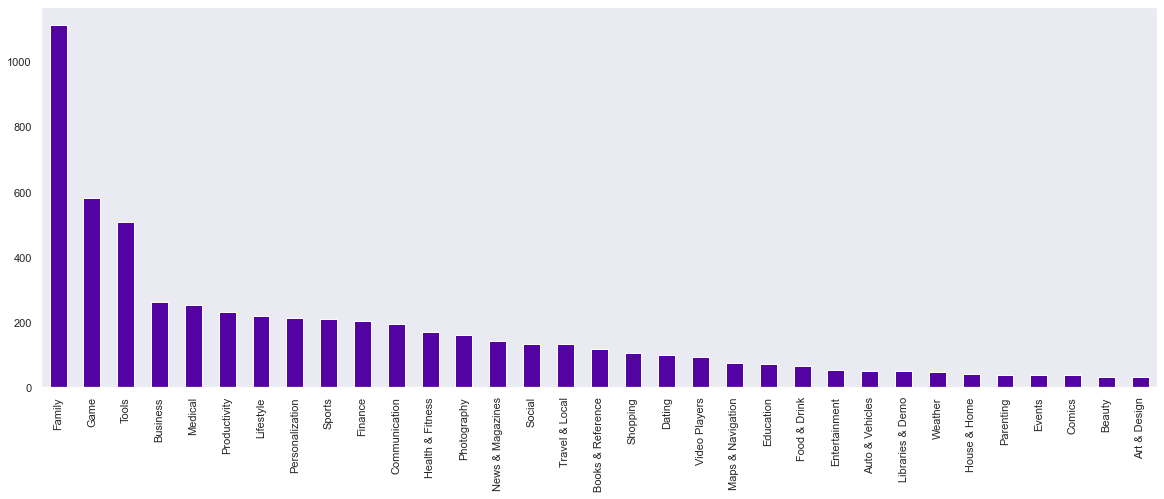

In [19]:
train_set.Category.value_counts().plot(kind = 'bar', figsize = (20,7));

Viendo ambas graficas, se ve que lo mas significativo de la col Genre ya esta en category, mientras que el resto son muy pocas instances que puede constribuir a overfittear.. 
Me fijo si en los primeros datos de genre (eq a category) hay datos diferentes que puedan sumar..

In [20]:
train_set.head()

,Category,Rating,Reviews,Installs,Type,Price,Content Rating,Genres,Last Updated,Android Ver,Size
ID,,,,,,,,,,,
0,Travel & Local,1,149723,"10,000,000+",Free,0,Everyone,Travel & Local,2018-06-13,4.0 and up,4.1
1,Lifestyle,0,853,"100,000+",Free,0,Everyone,Lifestyle,2018-03-22,4.1 and up,34.0
2,Food & Drink,1,61881,"5,000,000+",Free,0,Everyone,Food & Drink,2018-04-10,Varies with device,NaN
3,Tools,0,21943,"5,000,000+",Free,0,Everyone,Tools,2016-10-19,2.3 and up,2.3
4,Family,1,6,"1,000+",Free,0,Everyone,Education,2018-01-24,4.1 and up,9.2


In [21]:
#vemos ahora la android Version
train_set['Android Ver'].unique()

array(['4.0 and up', '4.1 and up', 'Varies with device', '2.3 and up',
       '1.6 and up', '4.0.3 and up', '3.0 and up', '4.3 and up',
       '5.0 and up', '4.4 and up', '4.2 and up', '2.2 and up',
       '7.0 and up', '2.3.3 and up', '2.0.1 and up', '2.1 and up',
       '2.0 and up', '1.5 and up', '3.2 and up', '8.0 and up',
       '6.0 and up', '5.1 and up', '4.4W and up', '1.0 and up',
       '2.2 - 7.1.1', '3.1 and up', '7.1 and up', '5.0 - 8.0',
       '7.0 - 7.1.1', '5.0 - 7.1.1', '4.0.3 - 7.1.1'], dtype=object)

In [22]:
def formato_version(x):
    if re.match(r'\d.\d\s\w+\s\w+', x) != None:
        return str(x)[:-7]
    elif re.match(r'\d.\d.\d\s\w+\s\w+', x) != None:
        return str(x)[:-7]
    elif re.match(r'\d.\d\w', x) != None:
        return str(x)[:-8]
    elif str(x) == 'Varia':
        return x
    else: #GUARDA QUE ACA NO TAS TRATANDO EL VARIES WITH DEVICE!
        x = 'acotado'
        return x

for df in [train_set, test_set]:
    df['Vers Android'] = df['Android Ver'].apply(formato_version)
    df.drop('Android Ver', axis = 1, inplace = True)

In [23]:
#vemos la columna precio ahora
train_set.Price = train_set.Price.astype(float)
train_set.Price.max()

399.99

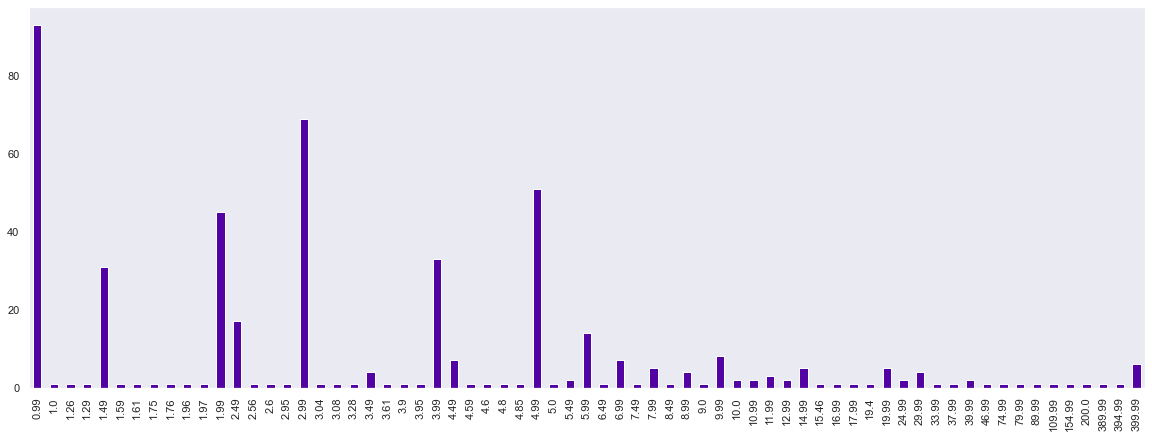

In [24]:
precios = pd.Series(train_set.Price.value_counts()).sort_index(ascending = True)
precios.iloc[1:].plot(kind = 'bar',figsize = (20, 7)); #no incluyo el 0 que son todas las app gratis asi no se me va al choto
#sns.barplot(x = precios.iloc[1:].index, y = precios.iloc[1:].values);


#se puede categorizar y ahi rajamos la columna type si es free o no.
#este grafico ayuda a ver como categorizarlo
#se completa el analisis viendo como influye eso en el precio

In [25]:
for df in [train_set, test_set]:
    df.drop('Type', axis = 1, inplace = True)

In [26]:
#veo la col content

train_set['Content Rating'].value_counts()

#Unrated deberia ser everyone para no overfittear ese dato..
#Adults only 18+ deberia ser Mature 17+

Everyone           4764
Teen                597
Mature 17+          234
Everyone 10+        189
Adults only 18+       3
Unrated               1
Name: Content Rating, dtype: int64

In [27]:
for df in [train_set, test_set]:
    df['Content Rating'] = df['Content Rating'].str.replace('Adults only 18+', 'Mature 17+', regex = False) 
    #sino pongo regex False me lee el + como algo de regex y me salen dos + en vez de uno en el output
    df['Content Rating'] = df['Content Rating'].str.replace('Unrated', 'Everyone')

train_set['Content Rating'].value_counts()

Everyone        4765
Teen             597
Mature 17+       237
Everyone 10+     189
Name: Content Rating, dtype: int64

In [28]:
#vemos ahora la columna con fechas..
#como ya esta parsed puedo usar fn de la libreria time
print(train_set['Last Updated'].min())#saco la fecha mas vieja
print(train_set['Last Updated'].max())#y la mas nueva
print((train_set['Last Updated'].max() - train_set['Last Updated'].min()).days)
#de 2010 a 2018 la cuestion

2010-05-21 00:00:00
2018-08-08 00:00:00
3001


In [29]:
#elimino los dias que son poco imp
for df in [train_set, test_set]:
    df['Last Updated'] = df['Last Updated'].dt.strftime('%m-%Y')
train_set.head()    

,Category,Rating,Reviews,Installs,Price,Content Rating,Genres,Last Updated,Size,Vers Android
ID,,,,,,,,,,
0,Travel & Local,1,149723,"10,000,000+",0.0,Everyone,Travel & Local,06-2018,4.1,4.0
1,Lifestyle,0,853,"100,000+",0.0,Everyone,Lifestyle,03-2018,34.0,4.1
2,Food & Drink,1,61881,"5,000,000+",0.0,Everyone,Food & Drink,04-2018,NaN,acotado
3,Tools,0,21943,"5,000,000+",0.0,Everyone,Tools,10-2016,2.3,2.3
4,Family,1,6,"1,000+",0.0,Everyone,Education,01-2018,9.2,4.1


In [30]:
test_set.head()
test_set.Price = test_set.Price.astype(float)
test_set.head()

,Category,Reviews,Installs,Price,Content Rating,Genres,Last Updated,Size,Vers Android
ID,,,,,,,,,
5788,Lifestyle,10,"1,000+",0.0,Everyone,Lifestyle,01-2018,3.0,4.1
5789,Personalization,7146,"1,000,000+",0.0,Everyone 10+,Personalization,02-2018,14.0,4.0
5790,Shopping,2221,"100,000+",0.0,Everyone,Shopping,07-2018,NaN,acotado
5791,Shopping,21,100+,0.0,Everyone,Shopping,10-2017,2.5,4.2
5792,Travel & Local,2822,"100,000+",0.0,Everyone,Travel & Local,07-2018,27.0,4.1


Deteccion de Outliers

# Analizo los datos

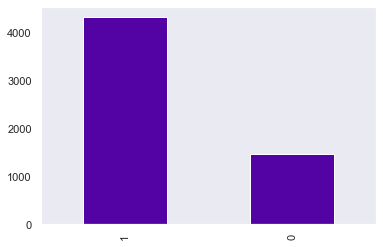

In [31]:
train_set.Rating.value_counts().plot(kind = 'bar');
#aprox el 70% de las apps del set son exitosas

In [32]:
train_set.head()

,Category,Rating,Reviews,Installs,Price,Content Rating,Genres,Last Updated,Size,Vers Android
ID,,,,,,,,,,
0,Travel & Local,1,149723,"10,000,000+",0.0,Everyone,Travel & Local,06-2018,4.1,4.0
1,Lifestyle,0,853,"100,000+",0.0,Everyone,Lifestyle,03-2018,34.0,4.1
2,Food & Drink,1,61881,"5,000,000+",0.0,Everyone,Food & Drink,04-2018,NaN,acotado
3,Tools,0,21943,"5,000,000+",0.0,Everyone,Tools,10-2016,2.3,2.3
4,Family,1,6,"1,000+",0.0,Everyone,Education,01-2018,9.2,4.1


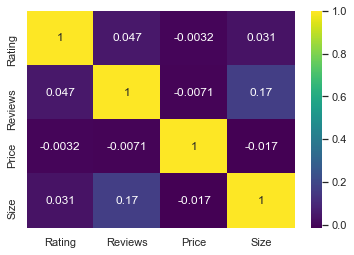

In [33]:
corr_matrix = train_set.corr()
sns.heatmap(corr_matrix, cmap = 'viridis', annot = True)

Parece interesante que la corr mas alta sea entre size y revies, ploteamos eso

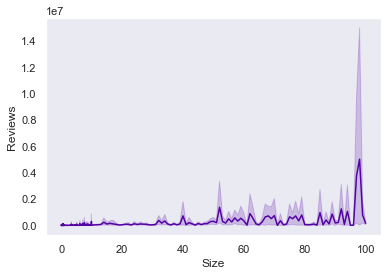

In [34]:
sns.lineplot(x = train_set['Size'], y = train_set['Reviews'])
#aparentemente con mas size hay mas reviews

Investigamos ahora si las installs estan relacionadas con las reviews...

In [35]:
#le saco el + para vizualizar mejor
def limpiar_installs(x):
    x = x.replace(',','') #python no puede convertir a numero valores que tengan . o , ! por mas gil que parezca
    return int(str(x)[:-1])
for df in [train_set, test_set]:
    df['Descargas'] = df['Installs'].apply(limpiar_installs)
    df.drop('Installs', axis = 1, inplace = True)
train_set.head(10)    

,Category,Rating,Reviews,Price,Content Rating,Genres,Last Updated,Size,Vers Android,Descargas
ID,,,,,,,,,,
0,Travel & Local,1,149723,0.00,Everyone,Travel & Local,06-2018,4.100000,4.0,10000000
1,Lifestyle,0,853,0.00,Everyone,Lifestyle,03-2018,34.000000,4.1,100000
2,Food & Drink,1,61881,0.00,Everyone,Food & Drink,04-2018,NaN,acotado,5000000
3,Tools,0,21943,0.00,Everyone,Tools,10-2016,2.300000,2.3,5000000
4,Family,1,6,0.00,Everyone,Education,01-2018,9.200000,4.1,1000
5,Tools,0,138,4.99,Everyone,Tools,03-2015,0.137695,1.6,5000
6,Art & Design,1,13,0.00,Everyone,Art & Design,03-2018,4.500000,4.0.3,1000
7,Medical,1,5,0.00,Everyone,Medical,01-2018,17.000000,4.0,1000
8,Family,1,97,0.00,Everyone,Entertainment,01-2018,2.600000,4.0,10000


C:\Users\desar\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\desar\Anaconda3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


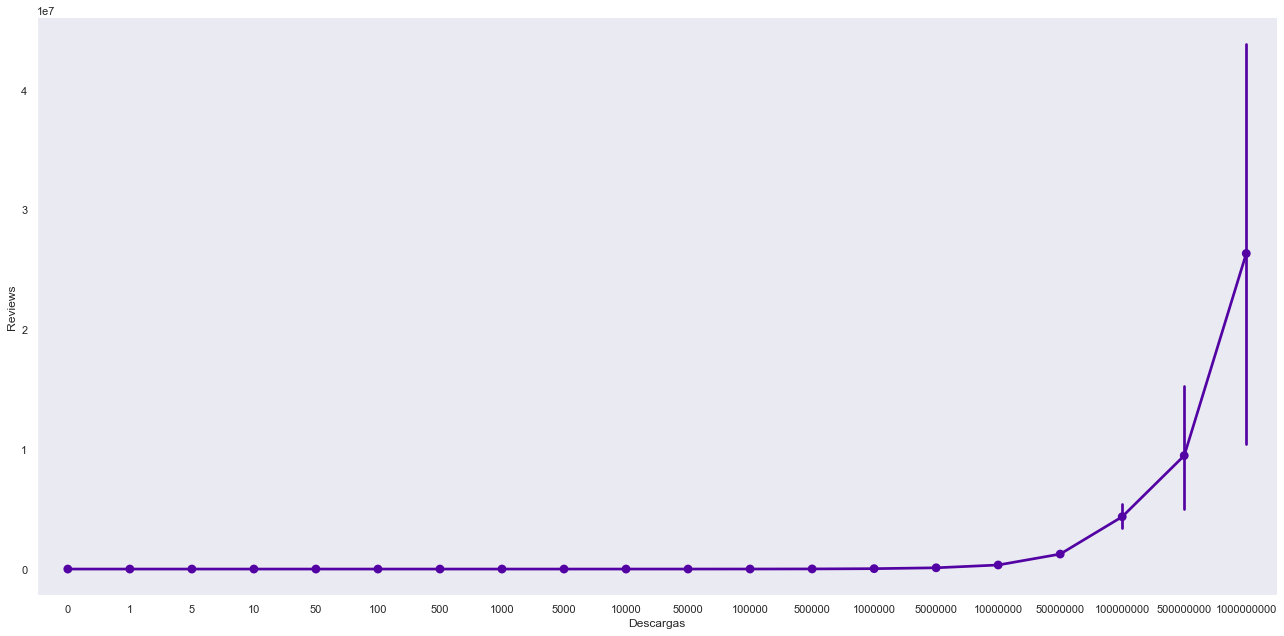

In [36]:
sns.factorplot(x = 'Descargas', y = 'Reviews', data = train_set, size = 9, aspect = 2)

#logicamente a mas descargas, mas reviews

me faltan muchos datos que no aparecen ahi porque son columnas que no estas como numericas
hay que hacerles un mapping para categorizarlas

In [37]:
train_set[['Content Rating','Rating', 'Reviews', 'Descargas']].groupby('Content Rating').mean()
#no hay tendencia marcada con este dato..

,Rating,Reviews,Descargas
Content Rating,,,
Everyone,0.745645,179405.379433,6.957874e+06
Everyone 10+,0.756614,681249.634921,1.086296e+07
Mature 17+,0.725738,262962.911392,7.774347e+06
Teen,0.752094,518068.949749,1.327376e+07


C:\Users\desar\Anaconda3\lib\site-packages\seaborn\axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


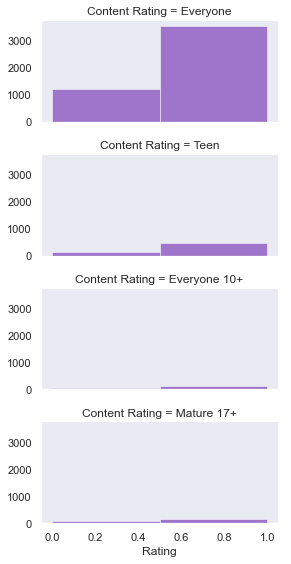

In [38]:
grid = sns.FacetGrid(train_set, row='Content Rating', size=2.0, aspect=2.0)
grid.map(plt.hist, 'Rating', alpha=.5, bins = 2)
grid.add_legend();

#ver como corregir esto!

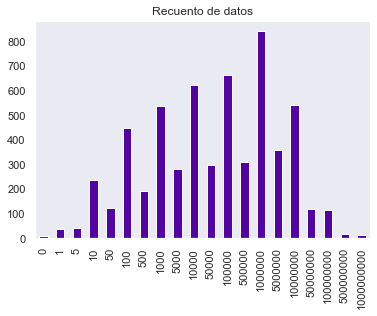

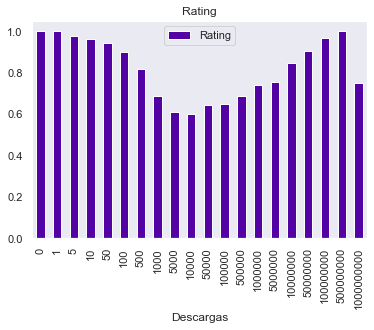

In [39]:
train_set.Descargas.value_counts().sort_index(ascending = True).plot(kind = 'bar', title = 'Recuento de datos')
train_set[['Descargas','Rating']].groupby('Descargas').mean().sort_values(by = 'Descargas').plot(kind = 'bar',
                                                                                                title = 'Rating');
plt.show()

#vemos que a mas orden de magnitud baja la cuestion porque hay muchos mas casos y se estabiliza en el promedio gral de 70%
#se deberia acotar diferentes, no con un minimo de 0+ 1+ o even 1000+, lo vemos mejor en un value_count

Sacando el bias de pocas instances para las apps con pocos datos (pocas descargas) vemos que 
la tendencia sube cuando aumentan las descargas.

vemos que la particion en 5, 50, 500 es menos representativa y que podria generalizarse mas!
Tamb podemos crear una nuvea col que sea muchas installs y pocas installs para los vaores extremos con pocos datos
para no overfittear!
Es raro que con tan pocas descargas sea considerada exitosa

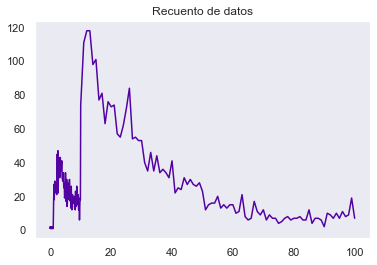

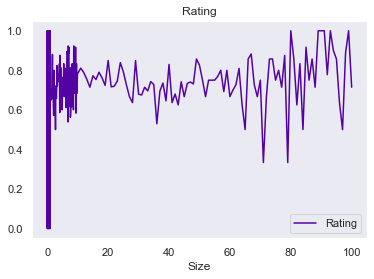

In [40]:
#vemos que onda el Size
train_set.Size.value_counts().sort_index(ascending = True).plot(title = 'Recuento de datos');
train_set[['Size','Rating']].groupby('Size').mean().sort_values(by = 'Size').plot(title = 'Rating')
plt.show()

Es un linea recta casi la relacion... a excepcion del comienzo que se ve claramente que es por falta de datos
El size no incide directamente sobre el rating, pero si sobre la cantidad de reviews como ya vimos,
y las reviews con la cantidad de descargas

Vemos la ult actualizacion

In [41]:
#Visualizo el last update en quarters como para tener mejor idea de la incidencia en el rating

for df in [train_set, test_set]:
    df['Last Updated'] = pd.to_datetime(df['Last Updated'])
    df['Last Updated YQ'] = pd.PeriodIndex(df['Last Updated'], freq='Q')
    df.drop('Last Updated', axis = 1, inplace = True)
train_set.head(2)

,Category,Rating,Reviews,Price,Content Rating,Genres,Size,Vers Android,Descargas,Last Updated YQ
ID,,,,,,,,,,
0,Travel & Local,1,149723,0.0,Everyone,Travel & Local,4.1,4.0,10000000,2018Q2
1,Lifestyle,0,853,0.0,Everyone,Lifestyle,34.0,4.1,100000,2018Q1


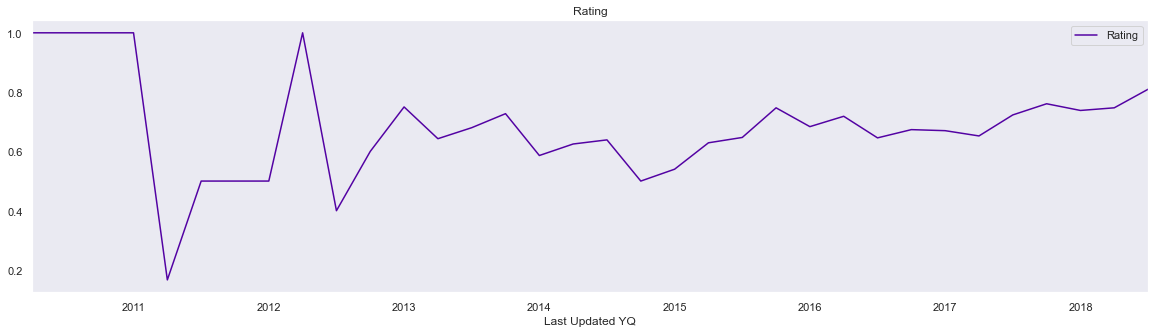

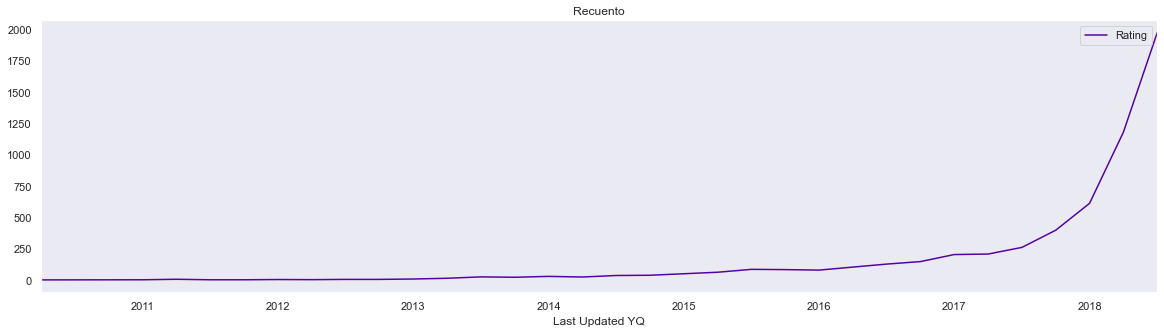

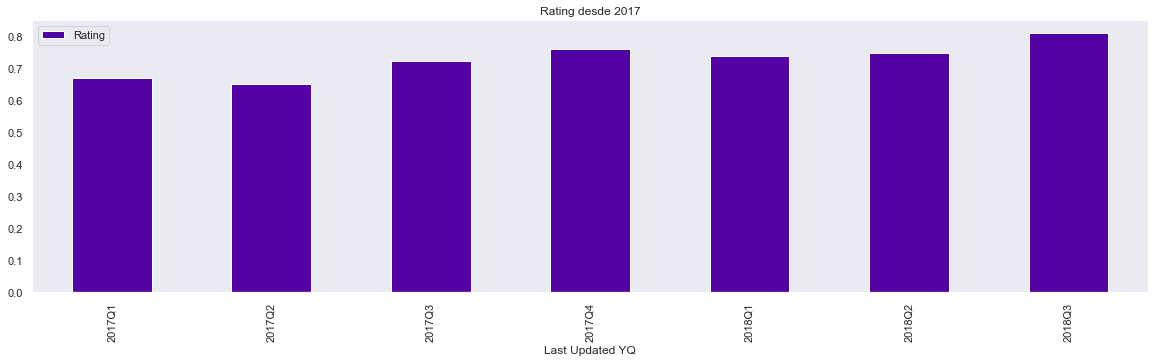

In [42]:
train_set[['Last Updated YQ','Rating']].groupby('Last Updated YQ').mean().sort_values(by = 'Last Updated YQ').plot( 
    figsize = (20,5), title = 'Rating')
train_set[['Last Updated YQ','Rating']].groupby('Last Updated YQ').count().sort_values(by = 'Last Updated YQ').plot(
    figsize = (20,5), title = 'Recuento')
train_set[['Last Updated YQ','Rating']].groupby('Last Updated YQ').mean().loc['2017Q1':].sort_values(
    by = 'Last Updated YQ').plot(kind = 'bar', figsize = (20,5), title = 'Rating desde 2017')
plt.show()

#leve tendencia a mejor rating a medida que esta mas actualizado. Analizando la curva desde 2017 
#que es donde habría variación más significativa por la cantidad de datos de la graf de recuento

Ahora vemos la version

C:\Users\desar\Anaconda3\lib\site-packages\seaborn\categorical.py:3692: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


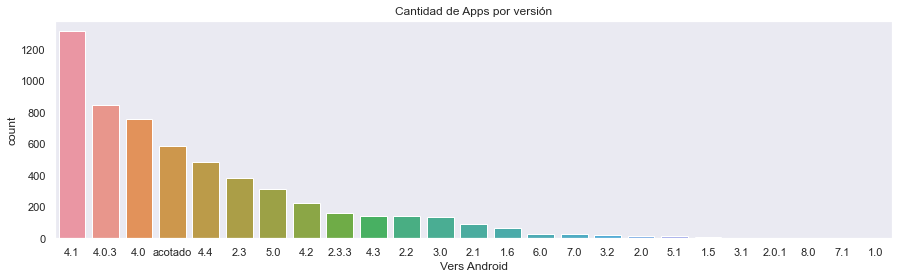

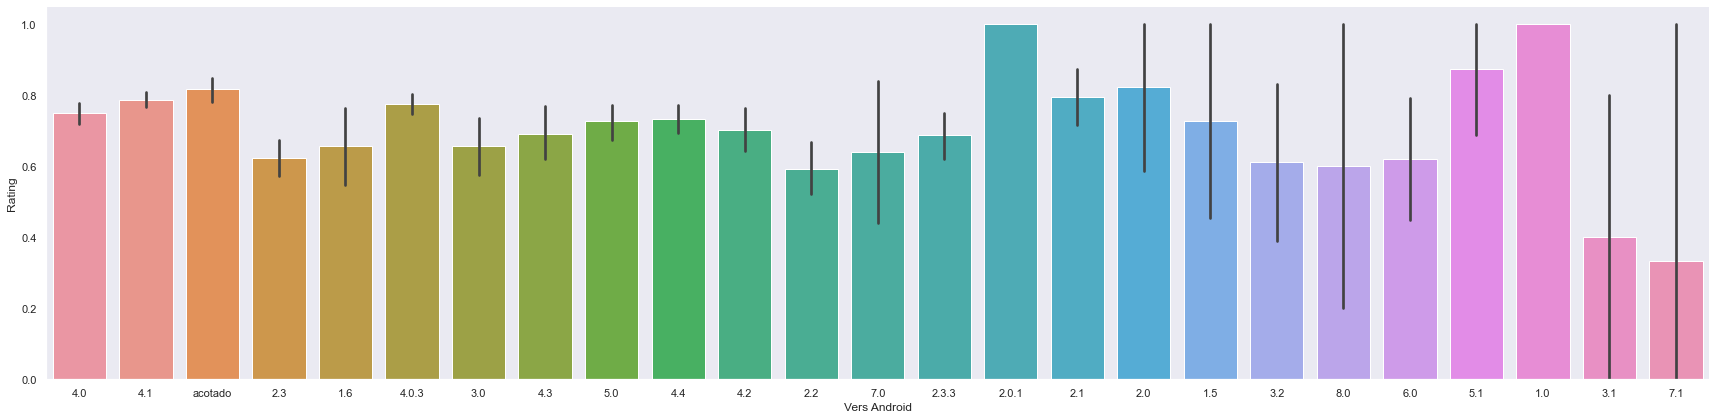

In [43]:
plt.figure(figsize=(15,4))
g = sns.countplot(train_set["Vers Android"], order = train_set['Vers Android'].value_counts().index)
plt.title('Cantidad de Apps por versión')
g = sns.catplot(x = "Vers Android", y = 'Rating', data = train_set, kind = 'bar', size = 6, aspect = 4,
                  order =  train_set['Vers Android'].unique())
plt.show()

#podemos categorizar en base a esto

Por ultimo, averiguo si la cantidad de reviews esta dada por la popularidad y en gran parte por el tiempo desde la
ult vez que fue actualizada

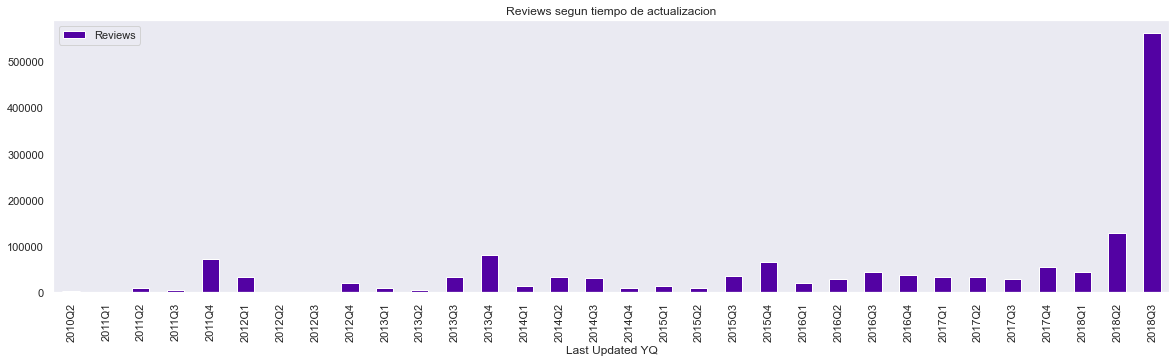

In [44]:
train_set[['Last Updated YQ','Reviews']].groupby('Last Updated YQ').mean().sort_values(by = 'Last Updated YQ').plot( 
    figsize = (20,5), title = 'Reviews segun tiempo de actualizacion', kind = 'bar')

#los actualizados son los que tienen mas reviews tambien
#da un idea de la interaccion de los usuarios y los developers con la app

In [45]:
train_set.head(10)

,Category,Rating,Reviews,Price,Content Rating,Genres,Size,Vers Android,Descargas,Last Updated YQ
ID,,,,,,,,,,
0,Travel & Local,1,149723,0.00,Everyone,Travel & Local,4.100000,4.0,10000000,2018Q2
1,Lifestyle,0,853,0.00,Everyone,Lifestyle,34.000000,4.1,100000,2018Q1
2,Food & Drink,1,61881,0.00,Everyone,Food & Drink,NaN,acotado,5000000,2018Q2
3,Tools,0,21943,0.00,Everyone,Tools,2.300000,2.3,5000000,2016Q4
4,Family,1,6,0.00,Everyone,Education,9.200000,4.1,1000,2018Q1
5,Tools,0,138,4.99,Everyone,Tools,0.137695,1.6,5000,2015Q1
6,Art & Design,1,13,0.00,Everyone,Art & Design,4.500000,4.0.3,1000,2018Q1
7,Medical,1,5,0.00,Everyone,Medical,17.000000,4.0,1000,2018Q1
8,Family,1,97,0.00,Everyone,Entertainment,2.600000,4.0,10000,2018Q1


Conclusiones:
    
Size esta levemente correlacionado con reviews,
a su vez, reviews esta altamente relac con descargas,
sacando datos con pocas instances, descargas esta postivimanete corr con el rating.
El tiempo tambien esta corr levemente con rating, subiendo mientras mas actualizado este.
las versiones 4.0 son claramente las mas populares.
Todas las variables de Category estan incluidas en Genre, pero no al reves.

entonces,

- se puede crear una variable que se llame especifico, en caso que el genre difiera de la category.
- para evitar overfittear, removemos valores bajos de vers android, size, descargas y last updated.
- podemos crear un var que sea reviews / descargas y ver si se relac mas con el rating.
- podemos crear una variable que combine factores de popularidad, como por ej ult actualizacion con reviews y desc

# Feature Engineering y preprocessing

In [46]:
#creo la var review / descarga, vemos que se correlaciona mejor

for df in [train_set, test_set]:
    df['review / desc'] = df['Reviews'] / df['Descargas']

train_set.corr()['Rating']

Rating           1.000000
Reviews          0.046603
Price           -0.003183
Size             0.031331
Descargas        0.043337
review / desc    0.101740
Name: Rating, dtype: float64

In [47]:
# creo var de popularidad

#defino que es popular si fue actualizada en el ultimo Quarter, y tiene un % de reviews o descargas mayor al 75% del total

for df in [train_set, test_set]:
    
    df['popular'] = 0

    Q3_desc = np.percentile(df['Descargas'], 75)
    Q3_reviews = np.percentile(df['Reviews'], 75)
    updated = '2018Q2' #tomo los dos ultimos quarters mejor

    df.loc[((df['Descargas'] >= Q3_desc)|(df['Reviews'] >= Q3_reviews)) & (df['Last Updated YQ'] >= updated), 
           'popular'] = 1

In [48]:
train_set['popular'].value_counts() #quedo razonablemente variado

0    4291
1    1497
Name: popular, dtype: int64

In [49]:
#creamos una variable que nos diga si el genero es especifico dentro de la categoria

train_set['Gen Especifico'] = 1
test_set['Gen Especifico'] = 1

train_set.loc[train_set['Genres'] == train_set['Category'], 'Gen Especifico'] = 0
test_set.loc[test_set['Genres'] == test_set['Category'], 'Gen Especifico'] = 0  

train_set.head()

,Category,Rating,Reviews,Price,Content Rating,Genres,Size,Vers Android,Descargas,Last Updated YQ,review / desc,popular,Gen Especifico
ID,,,,,,,,,,,,,
0,Travel & Local,1,149723,0.0,Everyone,Travel & Local,4.1,4.0,10000000,2018Q2,0.014972,1,0
1,Lifestyle,0,853,0.0,Everyone,Lifestyle,34.0,4.1,100000,2018Q1,0.008530,0,0
2,Food & Drink,1,61881,0.0,Everyone,Food & Drink,NaN,acotado,5000000,2018Q2,0.012376,1,0
3,Tools,0,21943,0.0,Everyone,Tools,2.3,2.3,5000000,2016Q4,0.004389,0,0
4,Family,1,6,0.0,Everyone,Education,9.2,4.1,1000,2018Q1,0.006000,0,1


In [50]:
train_set.corr()['Rating'] 

#Popular tiene linda correlacion
#gen especifico no

Rating            1.000000
Reviews           0.046603
Price            -0.003183
Size              0.031331
Descargas         0.043337
review / desc     0.101740
popular           0.111881
Gen Especifico   -0.007643
Name: Rating, dtype: float64

In [51]:
train_set.head(10)

,Category,Rating,Reviews,Price,Content Rating,Genres,Size,Vers Android,Descargas,Last Updated YQ,review / desc,popular,Gen Especifico
ID,,,,,,,,,,,,,
0,Travel & Local,1,149723,0.00,Everyone,Travel & Local,4.100000,4.0,10000000,2018Q2,0.014972,1,0
1,Lifestyle,0,853,0.00,Everyone,Lifestyle,34.000000,4.1,100000,2018Q1,0.008530,0,0
2,Food & Drink,1,61881,0.00,Everyone,Food & Drink,NaN,acotado,5000000,2018Q2,0.012376,1,0
3,Tools,0,21943,0.00,Everyone,Tools,2.300000,2.3,5000000,2016Q4,0.004389,0,0
4,Family,1,6,0.00,Everyone,Education,9.200000,4.1,1000,2018Q1,0.006000,0,1
5,Tools,0,138,4.99,Everyone,Tools,0.137695,1.6,5000,2015Q1,0.027600,0,0
6,Art & Design,1,13,0.00,Everyone,Art & Design,4.500000,4.0.3,1000,2018Q1,0.013000,0,0
7,Medical,1,5,0.00,Everyone,Medical,17.000000,4.0,1000,2018Q1,0.005000,0,0
8,Family,1,97,0.00,Everyone,Entertainment,2.600000,4.0,10000,2018Q1,0.009700,0,1


Hago Fill de los Size segun category

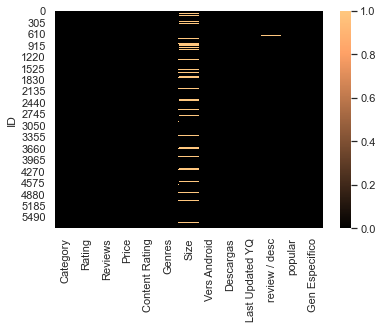

In [52]:
sns.heatmap(train_set.isnull(), cmap = 'copper', annot = False);
#los unicos NaN estan en Size..bastantes

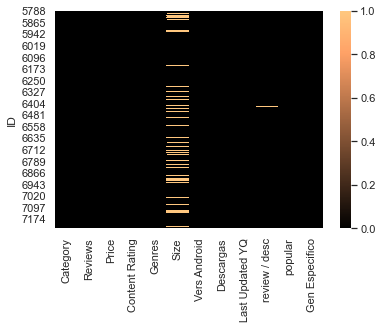

In [53]:
sns.heatmap(test_set.isnull(), cmap = 'copper', annot = False);

In [54]:
#apa, vemos que nos aparecio un NaN en review/desc
#lo filleamos asi nomas con la mean, porque es una sola instance en cada caso al parecer.
for df in [train_set, test_set]:
    df['review / desc'].fillna(method ='ffill', inplace = True)

In [55]:
for df in [train_set,test_set]:
    categorias = df['Category'].unique().tolist()
    for i in categorias:
            x = df.loc[df['Category'] == i, 'Size'].mean()
            df.loc[(df['Category'] == i) & (df['Size'].isnull()), 'Size'] = x

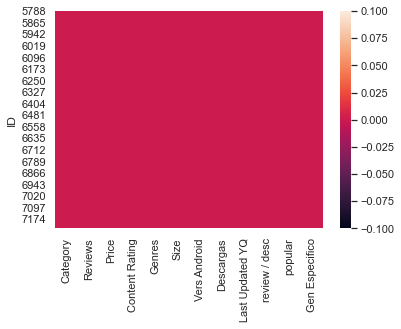

In [56]:
sns.heatmap(test_set.isnull());
#todo ok ya

In [57]:
test_set['Content Rating'].value_counts()

Everyone        1168
Teen             172
Mature 17+        60
Everyone 10+      48
Name: Content Rating, dtype: int64

In [58]:
def mapeo_contenido(x):
    if str(x) == 'Everyone':
        x = 0
    elif str(x) == 'Teen':
        x = 1
    elif str(x) == 'Mature 17+':
        x = 2
    elif str(x) == 'Everyone 10+':
        x = 3
        
    return x

for df in [train_set, test_set]:
    df['Contenido_mapped'] = df['Content Rating'].apply(mapeo_contenido)
    df.drop('Content Rating', axis = 1, inplace = True)

In [59]:
train_set.head(10)

,Category,Rating,Reviews,Price,Genres,Size,Vers Android,Descargas,Last Updated YQ,review / desc,popular,Gen Especifico,Contenido_mapped
ID,,,,,,,,,,,,,
0,Travel & Local,1,149723,0.00,Travel & Local,4.100000,4.0,10000000,2018Q2,0.014972,1,0,0
1,Lifestyle,0,853,0.00,Lifestyle,34.000000,4.1,100000,2018Q1,0.008530,0,0,0
2,Food & Drink,1,61881,0.00,Food & Drink,21.303846,acotado,5000000,2018Q2,0.012376,1,0,0
3,Tools,0,21943,0.00,Tools,2.300000,2.3,5000000,2016Q4,0.004389,0,0,0
4,Family,1,6,0.00,Education,9.200000,4.1,1000,2018Q1,0.006000,0,1,0
5,Tools,0,138,4.99,Tools,0.137695,1.6,5000,2015Q1,0.027600,0,0,0
6,Art & Design,1,13,0.00,Art & Design,4.500000,4.0.3,1000,2018Q1,0.013000,0,0,0
7,Medical,1,5,0.00,Medical,17.000000,4.0,1000,2018Q1,0.005000,0,0,0
8,Family,1,97,0.00,Entertainment,2.600000,4.0,10000,2018Q1,0.009700,0,1,0


MAPPING de Var Categoricas - Recorto instanced que tienen baja repeticion

In [60]:
#Empezamos con Descargas

#menos de 100, la mandamos a una var que sea -100 , mas de 5mill, a una que sea +5000000

def mapeo_desc(x):
    
    if str(x) == '0' or str(x) == '1'  or str(x) =='5' or str(x) == '10' or str(x) == '50':
        x = '-100'
    elif str(x) == '10000000' or str(x) == '50000000'  or str(x) =='5' or str(x) == '100000000':   
        x = '5000000'
    else:
        None
    
    return x

for df in [train_set, test_set]:
    df['Desc_mapped'] = df['Descargas'].apply(mapeo_desc)
    df.drop('Descargas', inplace = True, axis = 1)
  
train_set['Desc_mapped'].unique()    

array(['5000000', 100000, 5000000, 1000, 5000, 10000, 100, 500000, 50000,
       '-100', 1000000, 1000000000, 500, 500000000], dtype=object)

In [61]:
#Seguimos con Vers Android

#podemos generalizar desde las que tengan menos datos que 3.0 en la grafica
#generalizamos en vieja o nueva

def mapeo_vers(x):
    
    if str(x) == '1.0' or str(x) == '1.6'  or str(x) =='2.0' or str(x) == '1.5' or str(x) == '2.0.1' or str(x) == '2.1' or str(x) == '3.2' or str(x) == '3.1':
        x = 'old'
    elif str(x) == '5.1' or str(x) == '6.0'  or str(x) =='7.0' or str(x) == '7.1' or str(x) == '8.0':   
        x = 'new'
    else:
        None
    
    return x

for df in [train_set, test_set]:
    df['Vers_mapped'] = df['Vers Android'].apply(mapeo_vers)
    df.drop('Vers Android', inplace = True, axis = 1)
  
train_set['Vers_mapped'].unique()    

array(['4.0', '4.1', 'acotado', '2.3', 'old', '4.0.3', '3.0', '4.3',
       '5.0', '4.4', '4.2', '2.2', 'new', '2.3.3'], dtype=object)

In [62]:
#Seguimos con Genres
#Si no estan dentro de los 55 mas comunes, le llamamos otros

for df in [train_set, test_set]:

    genres_series = pd.Series(df.Genres.value_counts())
    lista_genre = genres_series.index.tolist()    
    for i in df['Genres']:
        if i in lista_genre[54:]:
            df['Genres'] = df['Genres'].str.replace(i, 'otros')  
        
len(train_set.Genres.value_counts())        

55

Preprocessing - Scaling de features continuas

In [63]:
pd.qcut(train_set['Size'], 7).value_counts()

(6.1, 11.0]       914
(15.845, 24.0]    857
(3.1, 6.1]        840
(0.0073, 3.1]     828
(40.0, 100.0]     811
(24.0, 40.0]      806
(11.0, 15.845]    732
Name: Size, dtype: int64

In [64]:
#Empezamos con el Size

#tomo 7 bins de datos, de manera arbitraria.
#el cut y no qcut da mejores resultados.

train_set['Size_band'] = pd.cut(train_set['Size'], 7)
train_set['Size_band'].value_counts().sort_index()

(-0.0917, 14.293]    3141
(14.293, 28.577]     1354
(28.577, 42.862]      587
(42.862, 57.146]      323
(57.146, 71.431]      161
(71.431, 85.715]       99
(85.715, 100.0]       123
Name: Size_band, dtype: int64

In [65]:
for df in [train_set, test_set]: 
    df.loc[df['Size'] <= 14.293, 'Size'] = 0
    df.loc[(df['Size'] > 14.293) & (df['Size'] <= 28.577), 'Size'] = 1 
    df.loc[(df['Size'] > 28.577) & (df['Size'] <= 42.862), 'Size'] = 2
    df.loc[(df['Size'] > 42.862) & (df['Size'] <= 57.146), 'Size'] = 3 
    df.loc[(df['Size'] > 57.146) & (df['Size'] <= 71.431), 'Size'] = 4
    df.loc[(df['Size'] > 71.431) & (df['Size'] <= 85.715), 'Size'] = 5
    df.loc[(df['Size'] > 85.715), 'Size'] = 6      

    df.Size = df.Size.astype(int)
    
train_set.drop('Size_band', axis = 1, inplace = True)
train_set.head() 

,Category,Rating,Reviews,Price,Genres,Size,Last Updated YQ,review / desc,popular,Gen Especifico,Contenido_mapped,Desc_mapped,Vers_mapped
ID,,,,,,,,,,,,,
0,Travel & Local,1,149723,0.0,Travel & Local,0,2018Q2,0.014972,1,0,0,5000000,4.0
1,Lifestyle,0,853,0.0,Lifestyle,2,2018Q1,0.008530,0,0,0,100000,4.1
2,Food & Drink,1,61881,0.0,Food & Drink,1,2018Q2,0.012376,1,0,0,5000000,acotado
3,Tools,0,21943,0.0,Tools,0,2016Q4,0.004389,0,0,0,5000000,2.3
4,Family,1,6,0.0,Education,0,2018Q1,0.006000,0,1,0,1000,4.1


In [66]:
#mismo procedimiento para las reviews

train_set['Rev_band'] = pd.qcut(train_set['Reviews'], 7)
train_set['Rev_band'].value_counts().sort_index()

(-0.001, 4.0]               857
(4.0, 38.0]                 800
(38.0, 301.143]             824
(301.143, 2526.0]           827
(2526.0, 17396.571]         826
(17396.571, 108211.571]     827
(108211.571, 78158306.0]    827
Name: Rev_band, dtype: int64

In [67]:
#No lo hago como con Sizes, sino con una fn mas apply

def mapeo_revs(x):
    
    if x <= 4:
        x = 0
    elif x <= 38:
        x = 1
    elif x <= 301:
        x = 2
    elif x <= 2526:
        x = 3
    elif x <= 17396:
        x = 4
    elif x <= 108211:
        x = 5
    else:
        x = 6
    
    return int(x)    
        
for df in [train_set, test_set]:
    df['Revs_mapped'] = df['Reviews'].apply(mapeo_revs)
    df.drop('Reviews', axis = 1, inplace = True)

train_set.drop('Rev_band', axis = 1, inplace = True)
train_set.head()     

,Category,Rating,Price,Genres,Size,Last Updated YQ,review / desc,popular,Gen Especifico,Contenido_mapped,Desc_mapped,Vers_mapped,Revs_mapped
ID,,,,,,,,,,,,,
0,Travel & Local,1,0.0,Travel & Local,0,2018Q2,0.014972,1,0,0,5000000,4.0,6
1,Lifestyle,0,0.0,Lifestyle,2,2018Q1,0.008530,0,0,0,100000,4.1,3
2,Food & Drink,1,0.0,Food & Drink,1,2018Q2,0.012376,1,0,0,5000000,acotado,5
3,Tools,0,0.0,Tools,0,2016Q4,0.004389,0,0,0,5000000,2.3,5
4,Family,1,0.0,Education,0,2018Q1,0.006000,0,1,0,1000,4.1,1


In [68]:
#A precio lo mapeo segun los picos de la grafica con el value counts de Price

def mapeo_price(x):
    
    if x == 0:
        x = 0
    elif x <= 1.49:
        x = 1
    elif x <= 1.99:
        x = 2
    elif x <= 2.99:
        x = 3
    elif x <= 3.49:
        x = 4
    elif x <= 4.49:
        x = 5
    elif x <= 5.49:
        x = 6
    elif x <= 9.49:
        x = 7
    elif x <= 19.99:
        x = 8
    elif x <= 39.99:
        x = 9
    else:
        x = 10  
        
    return x    
        
for df in [train_set, test_set]:
    df['Price_mapped'] = df['Price'].apply(mapeo_revs) #ojo que pusiste revs aca! lo dejo porque da un mejor result.
#fijate que podes hacer con este mapping.. lo acorte a 8 bins y me dio peor
#lo deje en gratis o pago y tamb me dio peor.
#en revs como que lo separa de 0 a 4, de 4 a 38 y de mas de 38..
    df.drop('Price', axis = 1, inplace = True)        

OH de features categoricas

In [69]:
#Tengo que juntar los dos datasets para llamar la func get dummies asegurandome de que queden la misma cantidad de
#features en cada uno! si la llamo por separado se me van a quedar uneven las features

columns = train_set.columns.tolist()
columns.remove('Rating')
X = train_set[columns]

dataset = pd.concat([X, test_set], axis = 0)

dataset = pd.get_dummies(dataset, columns = ["Category"], prefix = 'Cat')
dataset = pd.get_dummies(dataset, columns = ["Genres"], prefix = 'Cat')
dataset = pd.get_dummies(dataset, columns = ['Last Updated YQ'], prefix = 'Cat')
dataset = pd.get_dummies(dataset, columns = ['Desc_mapped'], prefix = 'Cat')
dataset = pd.get_dummies(dataset, columns = ['Vers_mapped'], prefix = 'Cat')
dataset = pd.get_dummies(dataset, columns = ['Revs_mapped'], prefix = 'Cat')
dataset = pd.get_dummies(dataset, columns = ['Size'], prefix = 'Cat')
dataset = pd.get_dummies(dataset, columns = ['Price_mapped'], prefix = 'Cat')

In [70]:
X_ok = dataset.iloc[0:5788]
test_ok = dataset.iloc[5788:]
test_ok.head()

,review / desc,popular,Gen Especifico,Contenido_mapped,Cat_Art & Design,Cat_Auto & Vehicles,Cat_Beauty,Cat_Books & Reference,Cat_Business,Cat_Comics,...,Cat_1,Cat_2,Cat_3,Cat_4,Cat_5,Cat_6,Cat_0,Cat_1,Cat_2,Cat_3
ID,,,,,,,,,,,,,,,,,,,,,
5788,0.010000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5789,0.007146,0,0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5790,0.022210,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
5791,0.210000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5792,0.028220,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0


In [71]:
y = train_set['Rating'] #creamos la matriz con las labels
X_ok.head()

,review / desc,popular,Gen Especifico,Contenido_mapped,Cat_Art & Design,Cat_Auto & Vehicles,Cat_Beauty,Cat_Books & Reference,Cat_Business,Cat_Comics,...,Cat_1,Cat_2,Cat_3,Cat_4,Cat_5,Cat_6,Cat_0,Cat_1,Cat_2,Cat_3
ID,,,,,,,,,,,,,,,,,,,,,
0,0.014972,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0.008530,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
2,0.012376,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
3,0.004389,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0.006000,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


# Modelling

In [72]:
X_ok.shape, test_ok.shape, y.shape #todo ok

((5788, 174), (1448, 174), (5788,))

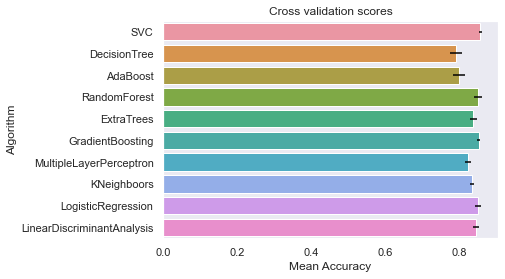

In [73]:
# Testeo diferentes algoritmos

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

kfold = StratifiedKFold(n_splits=10)

random_state = 42
classifiers = []
classifiers.append(SVC(random_state=random_state, probability = True))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),
                                      random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_ok, y, scoring = "f1", cv = kfold, n_jobs=-1))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC",
                                    "DecisionTree","AdaBoost","RandomForest","ExtraTrees",
                                    "GradientBoosting","MultipleLayerPerceptron","KNeighboors",
                                    "LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res ,orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean f1 score")
g = g.set_title("Cross validation scores")

In [74]:
cv_res.sort_values(by = 'CrossValMeans', ascending = False)

,CrossValMeans,CrossValerrors,Algorithm
0,0.858523,0.003780,SVC
5,0.853601,0.003184,GradientBoosting
8,0.851603,0.008278,LogisticRegression
3,0.851494,0.011301,RandomForest
9,0.846444,0.007768,LinearDiscriminantAnalysis
4,0.839626,0.010484,ExtraTrees
7,0.835217,0.005940,KNeighboors
6,0.824458,0.008615,MultipleLayerPerceptron
2,0.800383,0.015960,AdaBoost
1,0.792822,0.017161,DecisionTree


#el Random Forest es el mas picante, elijo best params

RFC = RandomForestClassifier(random_state = random_state)


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 5, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC, param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)

gsRFC.fit(X_ok,y)

RFC_best = gsRFC.best_estimator_
                 
# Best score
gsRFC.best_score_

RFC_best

ETC = ExtraTreesClassifier()

et_param_grid = {'max_features': [1, 5, 10],
                 "min_samples_split": [2, 3, 10],
                 "min_samples_leaf": [1, 3, 10],
                 "bootstrap": [False],
                 "n_estimators" :[100,300],
                 "criterion": ["gini"]}
    
gsETC = GridSearchCV(ETC, param_grid = et_param_grid, cv = kfold, scoring = 'accuracy', n_jobs= -1, verbose = 1)

gsETC.fit(X_ok, y)

ETC_best = gsETC.best_estimator_

gsETC.best_score_

ETC_best

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,300, 500],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)

gsGBC.fit(X_ok,y)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

GBC_best

MLP = MLPClassifier()

mlp_param_grid = {'activation' : ['logistic', 'tanh', 'relu'],
                 'solver' : ['adam'],
                 'alpha' : [0.001, 0.0001],
                 'shuffle' : [True],
                 'random_state' : [random_state],
                 'max_iter' : [300, 500]
              }

gsMLP = GridSearchCV(MLP, param_grid = mlp_param_grid, cv = kfold, scoring = 'accuracy', n_jobs = -1, verbose = 1)

gsMLP.fit(X_ok, y)

MLP_best = gsMLP.best_estimator_

gsMLP.best_score_


MLP_best

In [75]:
votingC = VotingClassifier(estimators=[('rfc', RandomForestClassifier(max_features = 10, min_samples_leaf=3, 
                                                                      min_samples_split=10,
                                                                      random_state=random_state)),
                    ('extc', ExtraTreesClassifier(random_state = random_state)),
                    ('lda', LinearDiscriminantAnalysis()),
                    ('mlp', MLPClassifier(random_state=random_state)),                  
                    ('gbc', GradientBoostingClassifier(random_state = random_state))],
                          voting = 'soft', n_jobs = 6)

#no elijo el SVC porque lo probe y va peor.. raro porque en el analisis de arriba me daba que era el mejor.
votingC = votingC.fit(X_ok, y)

#deberias probar con una log reg con hyperparameters distintos

In [76]:
voting_score = cross_val_score(votingC, X_ok, y, cv = kfold, scoring = 'f1', n_jobs = 6)
voting_score.mean()

#es casi igual que el Random Forest optimizado

0.8504842074025696

In [77]:
#para tener una mejor idea de como le esta calzando o errando, veo la confussion matrix,
#que me tira, sobre predicciones hechas en el train set, comparando con las labels
#la cantidad de true y false positives, e idem para los negatives
#1225 veces predijo bien el fracaso (true negative), y 216 predijo mal el exito (falso positivo)
#0 veces predijo mal el fracaso (falso negativo) y 4317 que era exitosa y si fue (true positive)
from sklearn.metrics import confusion_matrix
y_pred = votingC.predict(X_ok)
confusion_matrix(y, y_pred)

array([[1283,  188],
       [   1, 4316]], dtype=int64)

In [78]:
from sklearn.metrics import precision_score, recall_score

print('Precision = ', precision_score(y, y_pred)) # TP/(TP + FP) ... Que tan precisos fueron mis positivos %
print('Recall = ', recall_score(y, y_pred))       # TP/(TP + FN) ... cuantos falsos negativos me mande %

#confirmamos esto en la confussion matrix!

Precision =  0.9582593250444049
Recall =  0.9997683576557794


In [79]:
#computamos el f value, que es una metrica que combina precision y recall con la harmonic mean
#que es una media que le da mucha mas bola al low value del calculo
from sklearn.metrics import f1_score
f1_score(y, y_pred, average = 'macro')

0.9549856585022007

In [80]:
#Prediccion

y_pred = votingC.predict(test_ok) #ahora si predecimos sobre el test set

submission = pd.DataFrame({
        "id": test_ok.index,
        "rating": y_pred})

submission.to_csv('submission.csv', index = False )